# Chat-GPT Sentiment Analysis Challenge

Sentiment analysis is a powerful tool in natural language processing (NLP) that helps determine the underlying sentiment in textual data. This challenge focuses on analyzing tweets about ChatGPT, annotated for sentiment using ChatGPT itself.

I'll preprocess this  dataset and train sentiment classifiers using both a Support Vector Machine (SVM) and a Neural Network (NN) model, comparing the results of these models to determine which is more effective for sentiment analysis of social media data, while also explaining the "why" behind their differences in performance.


**Author:** Peter Favero  
**Email:** pmf66@cornell.edu  
**GitHub:** https://github.com/PeterFavero  
**LinkedIn:** https://www.linkedin.com/feed/


## Initial Setup

In [ ]:
# Essential libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from joblib import dump, load

# Palette to be used when plotting
palette = {"bad": "C3", "good": "C2", "neutral": "C0"}

## Load Dataset

In [ ]:
# Data-loading:
url = 'https://drive.google.com/file/d/1O6PAzQd808rWNxkyL3ToO3qpaBlvQ2zC/view?usp=share_link'
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
df = pd.read_csv(path, index_col=0)

In [ ]:
# Formatting: Reorder df so 'labels' is the first column, since I'll be adding more columns later
new_column_order = ['labels'] + [col for col in df.columns if col != 'labels']
df = df.reindex(columns=new_column_order)

## Preprocessing
Social media text can be quite messy, so it's crucial to clean and prepare the data before EDA and modeling. In this section, I'll clean and tokenizing the text in the dataset to prepare it for analysis, recording the length of the cleaned and tokenized tweets, and create training and testing datasets the data under a standard 80-20 split.

Cleaning:
1. Converting tweet to lowercase for standardization.
2. Remove \n, \r, URLS, HashTags, and mentions to reduce noise.
3. Remove numbers, newlines, puncuation to solely focus on textual data.
4. Reduce repeated characters to sets of two characters to avoid distortion of english words (ex: "cooool" becomes "cool").

Tokenizing:
1. Tokenize cleaned text for NN processing.
2. Using the industry-standard NLTK stop word list, remove common English stop words are removed. Additionally, remove some context-specific terms listed below. This step reduces noise and perserves words that carry substantial informational weight, creating a more focussed dataset.

In [ ]:
# Preprocessing: Setup

# Imports
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# Downloads for nltk
nltk.download('punkt')
nltk.download('stopwords')

# Declare nltk stop_words dataset
stop_words = set(stopwords.words('english'))

# Declare 'chatgpt', 'chat', 'gpt', 'ai' as context-specific stopwords
stop_words.update(['chatgpt', 'chat', 'gpt', 'ai', 'im', 'ive'])
# Declare stray n's as stopword since they can occasionally persist as leftovers from newlines
stop_words.update(['n', 'nn'])

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Prerocessing: Helper Functions

# Takes in a string 'text' and returns a cleaned version for suited for tokenization
def clean_text(text) :
  text = text.replace('\r', '').replace('\n', ' ').replace('\n', ' ').lower() #remove \n and \r and lowercase
  text = text.lower()  # Convert to lower case
  text = re.sub(r'http\S+', '', text)  # Remove URLs
  text = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', text)) #remove last hashtags
  text = " ".join(word.strip() for word in re.split('#|_', text)) #remove hashtags symbol from words in the middle of the sentence
  text = re.sub(r'@\S+', '', text)  # Remove mentions
  text = re.sub(r'\d+', '', text)  # Remove numbers
  text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
  text = re.sub(r'(.)\1+', r'\1\1', text)  # Reduce repeated characters to sets of two
  return text

# Takes in a string 'cleaned_text' and returns a tokenized list representing that text with stop words removed
def tokenize_text(cleaned_text) :
  return [word for word in word_tokenize(cleaned_text) if not word in stop_words]

# Takes in a string 'text' and returns a preprocessed version suited for analysis
def preprocess_text(text) :
  return tokenize_text(clean_text(text))

# Takes in a string list 'tokenized_text' and returns the length of the string that list represents a tokenization of
def tokenized_text_len(tokenized_text) :
  total_length = sum(len(token) for token in tokenized_text) # Sum the lengths of all the tokens
  if tokenized_text: total_length += len(tokenized_text) - 1 # Add number of spaces originally present for nonempty tokenized_text
  return total_length

In [ ]:
# Preprocessing: Clean and tokenize tweets to faciliate EDA and modelling (should take ≈ 45 seconds)
df['cleaned_tweets'] = df['tweets'].apply(clean_text)
df['preprocessed_tweets'] = df['cleaned_tweets'].apply(tokenize_text)

In [ ]:
# Prerocessing: Add length of cleaned and preprocessed tweets to df
df['cleaned_tweet_lengths'] = df['cleaned_tweets'].apply(len)
df['preprocessed_tweet_lengths'] = df['preprocessed_tweets'].apply(tokenized_text_len)
df['preprocessed_tweet_token_counts'] = df['preprocessed_tweets'].apply(len)

df

,labels,tweets,cleaned_tweets,preprocessed_tweets,cleaned_tweet_lengths,preprocessed_tweet_lengths,preprocessed_tweet_token_counts
0,neutral,ChatGPT: Optimizing Language Models for Dialog...,chatgpt optimizing language models for dialogue,"[optimizing, language, models, dialogue]",49,35,4
1,good,"Try talking with ChatGPT, our new AI system wh...",try talking with chatgpt our new ai system whi...,"[try, talking, new, system, optimized, dialogu...",112,66,10
2,neutral,ChatGPT: Optimizing Language Models for Dialog...,chatgpt optimizing language models for dialogu...,"[optimizing, language, models, dialogue, machi...",204,184,19
3,good,"THRILLED to share that ChatGPT, our new model ...",thrilled to share that chatgpt our new model o...,"[thrilled, share, new, model, optimized, dialo...",111,73,10
4,bad,"As of 2 minutes ago, @OpenAI released their ne...",as of minutes ago released their new chatgpt...,"[minutes, ago, released, new, nnand, use, right]",78,40,7
...,...,...,...,...,...,...,...
219289,bad,Other Software Projects Are Now Trying to Repl...,other software projects are now trying to repl...,"[software, projects, trying, replicate]",59,34,4
219290,good,I asked #ChatGPT to write a #NYE Joke for SEOs...,i asked chatgpt to write a nye joke for seos a...,"[asked, write, nye, joke, seos, delivered, nnw...",212,151,23
219291,bad,chatgpt is being disassembled until it can onl...,chatgpt is being disassembled until it can onl...,"[disassembled, dissemble]",57,22,2
219292,bad,2023 predictions by #chatGPT. Nothing really s...,predictions by chatgpt nothing really specifi...,"[predictions, nothing, really, specific, trend...",135,83,12


In [ ]:
# Prerocessing: Get count of neutral, good, and bad tweets
label_counts = df['labels'].value_counts()

In [ ]:
# Prerocessing: train-test split

# Use preprocessed tweets and their length as X-features, labels as y-features
X_train, X_test, y_train, y_test = train_test_split(df['preprocessed_tweets'], df['labels'], test_size=0.2, random_state=42)

# Convert from list of tokenized strings to back to arrays of strings for test datasets, as TIDF and Bert each have specific tokenizers
X_train = np.array([" ".join(tokens) for tokens in X_train])
X_test = np.array([" ".join(tokens) for tokens in X_test])

# Declare training/testing dataset size constants for later use
NUM_TRAINING_ENTRIES = len(X_train)
NUM_TESTING_ENTRIES = len(X_test)

print(f"Training on : {NUM_TRAINING_ENTRIES} entries.")
print(f"Testing on  : {NUM_TESTING_ENTRIES} entries.")

Training on : 175435 entries.
Testing on  : 43859 entries.


## Exploratory Data Analysis
Training ML models can be very complex, so, in this section, I'll analyze the dataset to uncover insights that may inform my modeling decisions. I'll will consider the following analyses, coming to conclusions that I've placed in comments at the top of each code section.

1. Distribution of tweet counts accross sentiment classes.

2. Distribution of tweet length after cleaning across different sentiments.

3. Distribution of token count after preprocessing across different sentiments.

4. Frequency of words in nuetral, positive, and negative tweets.


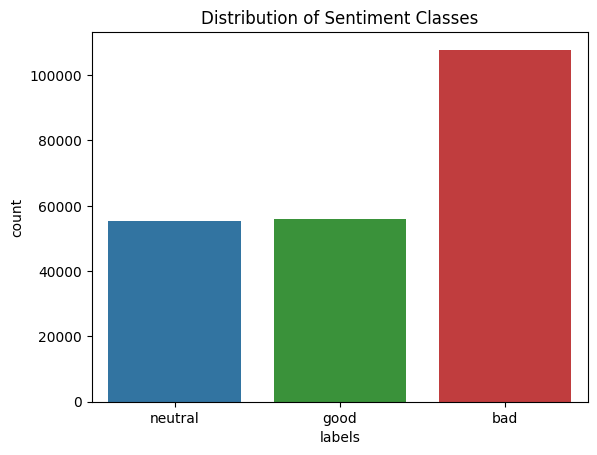

In [ ]:
# EDA #1: Distribution of sentiment classes

# Conclusion: We have significantly more negative tweets than positive or neutral tweets,
# meaning we have a class imbalance in our dataset. It is crucial to account for this class imbalance
# by weighting labels in the SVM and NN modelling sections, which you'll see me do later.

sns.countplot(x='labels', data=df, hue='labels', legend=False, palette=palette)
plt.title('Distribution of Sentiment Classes')
plt.show()

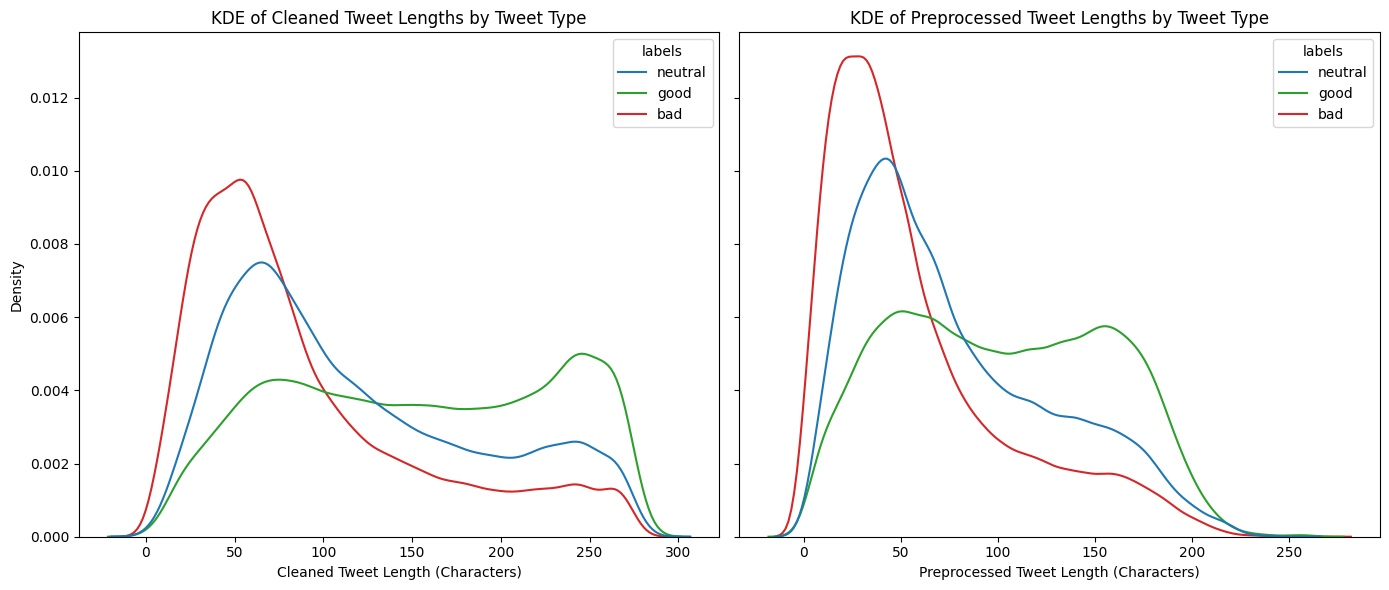

In [ ]:
# EDA #2: Tweet Length Distribution KDEs

# Visualize the distribution using Kernel Density Estimations to analyze the usefulness of length
# as a feature for our models based on its variance accross sentiment labels. A KDE, or Kernerl Desnity Estimation,
# is a way of estimating a continous probability density function (pdf) that is fit to
# a distribution's discrete probability mass function (pmf), allowing us to visually inspect the
# distribution of tweet lengths for each sentiment label without being bogged down by bar charts.

# Conclusion: Length is a useful classifier for sentiment, as negative tweets tend to be shorter,
# positive tweets tend be longer, and neutral tweets are somewhere in the middle based on the shape of the graph.
# Although there are some areas where a tweet of the given length is about equally likely to be in any of the sentiment classes,
# most lengths carry some information about our example, and our models can take this into account if we use tweet length as a feature.

# Set up the matplotlib figure with two subplots (sharey=True makes both plots share the same y-axis)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6), sharey=True)

# Plot KDEs for tweet length distribution (common_norm=False makes every label individually
# normalized so they are comparable even if one label has more data points than the others)

# KDE for cleaned tweet length distribution
sns.kdeplot(data=df, x='cleaned_tweet_lengths', hue='labels', bw_adjust=1, ax=axes[0], common_norm=False, palette=palette)
axes[0].set_title('KDE of Cleaned Tweet Lengths by Tweet Type')
axes[0].set_xlabel('Cleaned Tweet Length (Characters)')
axes[0].set_ylabel('Density')

# KDE for preprocessed tweet length distribution
sns.kdeplot(data=df, x='preprocessed_tweet_lengths', hue='labels', bw_adjust=1, ax=axes[1], common_norm=False, palette=palette)
axes[1].set_title('KDE of Preprocessed Tweet Lengths by Tweet Type')
axes[1].set_xlabel('Preprocessed Tweet Length (Characters)')
axes[1].set_ylabel('Density')

# Display both plots
plt.tight_layout()
plt.show()

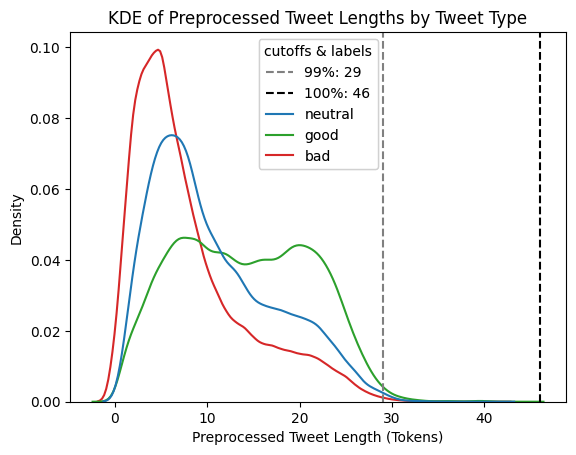

In [ ]:
# EDA: Tweet Token Count Distribution KDE

# Visualize number of tokens present within preprocessed tweets to enform decisions
# of max sequence length in our BERT/RoBERTa-nn later.

# Conclusion: 99% of our data fits within 29 tokens after preprocessing, and 100% fits within 46 tokens, counting padding tokens
# as explained below. For the purposes of our BERT/RoBERTa-nn later, we can use a max token cap that is as tight as possible without loss (46),
# or even a cap that is slightly lossy (32 is ultimately what I'll end up using), to optimize performance.

# KDE for preprocessed token count distribution
kdeplot = sns.kdeplot(data=df, x='preprocessed_tweet_token_counts', hue='labels', bw_adjust=1, common_norm=False, palette=palette)
plt.title('KDE of Preprocessed Tweet Token Counts by Tweet Type')
plt.xlabel('Preprocessed Tweet Length (Tokens)')
plt.ylabel('Density')

# Get the handles and labels from the Seaborn kdeplot
handles, labels = kdeplot.get_legend_handles_labels()

# Find the maximum x-value in 'preprocessed_tweet_token_counts',
# place a vertical line at max(x) + 2, such that if we set this as the token limit, all our data should fit losslessly.
# The '+2' accounts for special tokens such as [CLS] and [SEP] that are often added during tokenization in transformers-based models.
max_token_count = df['preprocessed_tweet_token_counts'].max()
plt.axvline(x=max_token_count + 2, color='black', linestyle='--')

# Place a vertical line at x' + 2, where x' is the 99th percentile of preprocessed tweet token counts,
# such that 99% of our data can fit into x' tokens or fewer. This way, we are establishing a cutoff point
# that accommodates the vast majority of our data while allowing for potential special tokens added by BERT/RoBERTa tokenization.
# The '+2' accounts for special tokens such as [CLS] and [SEP] that are often added during tokenization in transformers-based models.
percentile_99 = np.percentile(df['preprocessed_tweet_token_counts'], 99)
plt.axvline(x=percentile_99 + 2, color='gray', linestyle='--')

# Create custom legend and add custom legend for vertical lines and KDE plot
custom_lines = [plt.Line2D([0], [0], color='gray', linestyle='--'),
                plt.Line2D([0], [0], color='black', linestyle='--'),
                plt.Line2D([0], [0], color='C0'),
                plt.Line2D([0], [0], color='C2'),
                plt.Line2D([0], [0], color='C3')]
line_labels = [f'99%: {int(percentile_99) + 2}',
               f'100%: {int(max_token_count) + 2}',
               'neutral',
               'good',
               'bad']
combined_legend = plt.legend(custom_lines, line_labels, title='cutoffs & labels')
plt.gca().add_artist(combined_legend)

# Show the plot
plt.show()

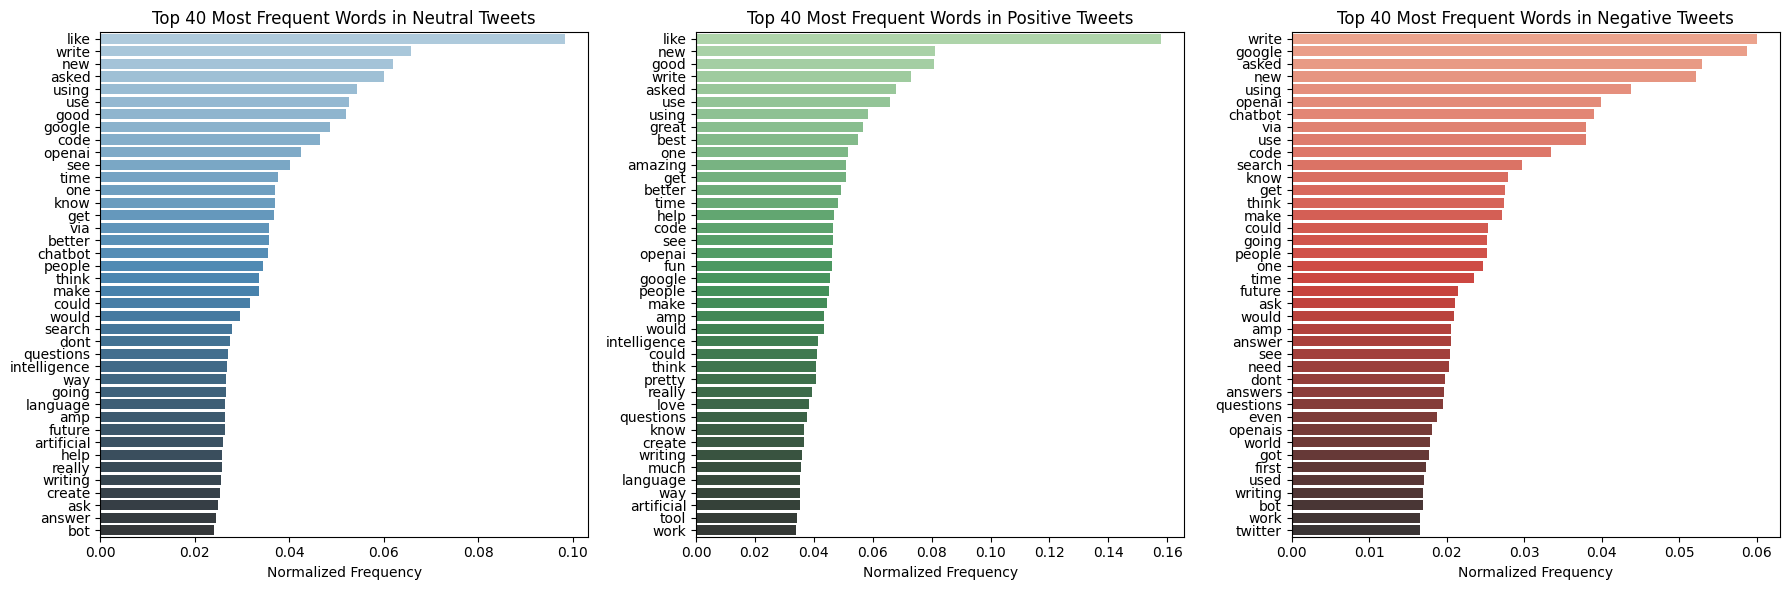

In [ ]:
# EDA: Word Frequencies

# Count and plot most common words in positive and negative tweets.

# Conclusion: Examining the plots, we can see some common optimistic/pessimistic words
# differentiate effectively between positive and negative classes. Further, this is extremely subjective, but
# there aren't many generic, low-information words left in the top words of any of the classes, meaning
# our removal of stop words went well.

# Imports
from collections import Counter

# Helper function to flatten a list of lists
def flatten(list_of_lists):
    return [item for sublist in list_of_lists for item in sublist]

# Separate the tweets by sentiment labels, flatten tweet lists and count occurences
neutral_tweets = df[df['labels'] == 'neutral']['preprocessed_tweets']
neutral_word_counts = Counter(flatten(neutral_tweets))
positive_tweets = df[df['labels'] == 'good']['preprocessed_tweets'].tolist()
positive_word_counts = Counter(flatten(positive_tweets))
negative_tweets = df[df['labels'] == 'bad']['preprocessed_tweets']
negative_word_counts = Counter(flatten(negative_tweets))

# Get the N most common words within neutral, positive, and negative Tweets:
N = 40

# Neutral Tweets
most_common_neutral = neutral_word_counts.most_common(N)
neutral_words = [word for word, count in most_common_neutral]
neutral_counts = [count for word, count in most_common_neutral]

# Positive Tweets
most_common_positive = positive_word_counts.most_common(N)
positive_words = [word for word, count in most_common_positive]
positive_counts = [count for word, count in most_common_positive]

# Negative Tweets
most_common_negative = negative_word_counts.most_common(N)
negative_words = [word for word, count in most_common_negative]
negative_counts = [count for word, count in most_common_negative]

# Plot Positive and Negative tweets side-by-side
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

# Frequency bar plot for neutral words
sns.barplot(x=neutral_counts/label_counts['neutral'], y=neutral_words, ax=ax[0], hue=neutral_words, legend=False, palette='Blues_d')
ax[0].set_title(f'Top {N} Most Frequent Words in Neutral Tweets')
ax[0].set_xlabel('Normalized Frequency')

# Frequency bar chart for positive words
sns.barplot(x=positive_counts/label_counts['good'], y=positive_words, ax=ax[1], hue=positive_words, legend=False, palette='Greens_d')
ax[1].set_title(f'Top {N} Most Frequent Words in Positive Tweets')
ax[1].set_xlabel('Normalized Frequency')

# Frequency bar chart for negative words
sns.barplot(x=negative_counts/label_counts['bad'], y=negative_words, ax=ax[2], hue=negative_words, legend=False, palette='Reds_d')
ax[2].set_title(f'Top {N} Most Frequent Words in Negative Tweets')
ax[2].set_xlabel('Normalized Frequency')

# Formatting
plt.tight_layout()
plt.show()

## Modeling (SVM)

Welcome to this section! Here, I'll train a Support Vector Machine (SVM) to perform sentiment analysis on our dataset.

**What is SVM?**  
Support Vector Machine (SVM) is a powerful and versatile supervised machine learning algorithm used for classification and regression tasks.  SVM works by finding the hyperplane that best divides a dataset into two classes.

**Why SVM for sentiment analysis?**   
SVM is suited for sentiment analysis because it can efficiently handle high-dimensional data, such as text data. When dealing with text, after vectorization, we often end up with thousands of features (words or n-grams) that represent the presence or frequency of terms within the documents. SVM can navigate this high-dimensional space to find the optimal hyperplane that separates the positive from the negative sentiments. Moreover, SVM's flexibility in choosing different kernel functions allows it to model non-linear relationships. This is useful in sentiment analysis where the decision boundary between positive and negative sentiments may not be linear. For instance, the same word could be used in different contexts with different sentiments, creating a complex decision surface, which the RBF kernel I'll ultimately end up using is suited for.


**Development Process:**   
1. Rescearched [SVM in the context of text classification](https://medium.com/scrapehero/sentiment-analysis-using-svm-338d418e3ff1).
2. Set up TfidfVectorizer to encode the data, based on its ability to reflect the importance of words in relation to the document and the entire corpus, as TF-IDF [(Term Frequency-Inverse Document Frequency)](https://monkeylearn.com/blog/what-is-tf-idf/#:~:text=TF%2DIDF%20(term%20frequency%2D,across%20a%20set%20of%20documents) emphasizes words that are more relevant to the context rather than simple word frequency without being too complicated either.
3. Appended length of the preprocessed tweet to the end of each feature vector and renormalized, as EDA #2 revealed length as a useful seperator for our data.
4. Trained linear classifier on entire dataset, achieving 87% accuracy.
5. Sought to do better: ran a quick gird search of c-values and gamma-values for rbf, polynomial, and sigmoid kernels on a 10,000 entry dataset to find optimal values used below.
6. Trained RBF classifier with c=10 and gamma=0.1 based on the grid search to achieve 88% accuracy as shown below.   

I considered this sufficient accuracy, as sklearn SVM, while not bad, isn't state-of-the-art NLP in 2024, so I decided to move onto the BERT/RoBERTa-NN and come back later if achieving high accuracy there wasn't feasible.

In [ ]:
# Setup: Imports
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from scipy.sparse import hstack

In [ ]:
# SVM Preprocessing:

# Initialize a TF-IDF Vectorizer which converts a collection of raw documents
# to a matrix of TF-IDF features. The parameters help filter out too common
# and too rare words, and apply sublinear TF scaling and IDF weighting.
vectorizer = TfidfVectorizer(min_df = 5,
                             max_df = 0.8,
                             sublinear_tf = True,
                             use_idf = True)

# Create TF-IDF feature matrices for the training and test sets
X_train_svm = vectorizer.fit_transform(X_train)
X_test_svm = vectorizer.transform(X_test)

# Calculate the length of each data point
X_train_lengths = np.array([len(x) for x in X_train])[:, np.newaxis]
X_test_lengths = np.array([len(x) for x in X_test])[:, np.newaxis]


# Normalize the lengths so that they're on the same scale as the TF-IDF features
scaler = StandardScaler()
X_train_lengths = scaler.fit_transform(X_train_lengths)
X_test_lengths = scaler.transform(X_test_lengths)

# Append the normalized lengths to the end of the TF-IDF feature vectors
X_train_svm = hstack([X_train_svm, X_train_lengths])
X_test_svm = hstack([X_test_svm, X_test_lengths])

# Compute class weights for the original string labels
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

# Create a mapping from the original string labels to their weights, so we can
# create SVMs with balanced weights
class_labels = np.unique(y_train)
class_weights_dict = {label: weight for label, weight in zip(class_labels, class_weights)}

In [ ]:
# SVM Training:
# ( May take some time )

# Instatiate SVM classifier

# Linear classifer:
# svm_classifier = SVC(kernel='linear', class_weight=class_weights_dict) # 87% effective after training on 80% of dataset in 50 minutes on my machine

"""
# grid search

# Define the parameter grid to search
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['rbf', 'poly', 'sigmoid']
}

# Instantiate SVM classifier
svm_classifier = SVC()

# Setup GridSearchCV
grid_search = GridSearchCV(svm_classifier, param_grid, refit=True, verbose=3)

# Fit the grid search to the data
start_time = time.time()
print(f"Begin grid search on {NUM_TRAINING_ENTRIES} entries:")
grid_search.fit(X_train_svm, y_train_svm)

# Print the results
print(f"Grid search complete in {round(time.time()-start_time,6)} sec.")
print(f"Best parameters found: {grid_search.best_params_}")
print(f"Best estimator found: {grid_search.best_estimator_}")

# Use the best estimator to make predictions
best_svm_classifier = grid_search.best_estimator_
"""

# RBF classifer: best parameters found for during above gridsearch on a 10000-entry training dataset.
svm_classifier = SVC(kernel='rbf', C=10, gamma=0.1, class_weight=class_weights_dict) # 88.5% effective after training on 80% of dataset in 80 minutes on my machine

# Fit the SVM classifier on the training data
start_time = time.time()
print(f"Begin training SVM classifier on {NUM_TRAINING_ENTRIES} entries:")
svm_classifier.fit(X_train_svm, y_train)
print(f"SVM classifier training complete in {round(time.time()-start_time,2)} sec.")

Begin training SVM classifier on 175435 entries:
SVM classifier training complete in 12320.53 sec.


In [ ]:
# SVM Testing: Make predictions on the test set (may take some 5 minutes)
y_pred_svm = svm_classifier.predict(X_test_svm)

# Calculate the accuracy
svm_accuracy = accuracy_score(y_test, y_pred_svm)
print(f"Accuracy of the SVM classifier on test data: {(100*svm_accuracy):.6f}%")

# Generate a classification report - we will come back to this report in the conclusion section
svm_report = classification_report(y_test, y_pred_svm)
print("\nClassification report for SVM classifier:\n")
print(svm_report)

Accuracy of the SVM classifier on test data: 87.929501%

Classification report for SVM classifier:

              precision    recall  f1-score   support

         bad       0.95      0.91      0.93     21474
        good       0.87      0.87      0.87     11204
     neutral       0.77      0.82      0.79     11181

    accuracy                           0.88     43859
   macro avg       0.86      0.87      0.87     43859
weighted avg       0.88      0.88      0.88     43859



In [ ]:
# Save SVM Model
dump(svm_classifier, 'SVM/svm_classifier')

['SVM/svm_classifier']

## Modeling (BERT/RoBERTa-NN, Simple Transformers)
Welcome to this section! Here, I'll train a BERT Neural-Network and RoBERTa Neural-Network to perform sentiment analysis on our dataset.

**What are BERT and RoBERTa?**  
BERT stands for Bidirectional Encoder Representations from Transformers and was the state-of-the-art open-source NLP model when Google Research Labs released it in 2018. RoBERTa, or Robust Optimized Bidirectional Encoder Representations from Transformers, is a fine-tuned and better-trained version of BERT.

**Why BERT/RoBERTa?**  
RoBERTa and its contemporaries mentioned below are the state-of-the-art in open-source NLP models today. The advantages of RoBERTa are essentially the same as the advantages of BERT, except that it requires more data and compute for higher peak precision, which could be a pro or a con in this project, with our large but not gigantic dataset. Thus, we'll train both models and see how they perform. We can break RoBERTa and BERT's strengths down based on the BERT acronym.
- Bidirectional: BERT models are trained to understand the context of a word based on all of its surroundings (left and right of the word). Unlike directional models, which read the text input sequentially (left-to-right or right-to-left), the bidirectional approach allows the model to capture more context, leading to a deeper understanding of the text.
- Encoder Representations: BERT uses the encoder portion of the Transformer model, which processes the entire input text at once. This allows it to capture complex relationships between words and phrases and encode this information into high-dimensional representations that can be used for a variety of NLP tasks.
- Transformers: At the heart of BERT are Transformer models, which rely on self-attention mechanisms to weigh the significance of each word in the context of the others. This allows BERT to dynamically adjust to the nuances of language, understanding that the same word can have different meanings in different situations. Most performance critical NLP done in industry uses transformers.

Further, RoBERTa and BERT leverage transfer learning, where the model is first pre-trained on a large corpus (called a base) to generally understanding of language structure and then fine-tuned on a smaller, task-specific dataset. It cannot be overstated how valuable this is to this project. The computational, data-aquistion, and hardware burden would have been enormous and far beyond the scope of this project without this pretraining. This two-stage training process allows BERT/RoBERTa to be highly effective in a wide range of NLP tasks without the need for prohibitive rescources and also specialize within specific tasks.

**Why BERT/RoBERTa over ELECTRA, XLNet, or T5?**  
While there are no  poor choices among these models, RoBERTa is recognized as being as cutting-edge as ELECTRA and XLNet and comes with a specific version pre-trained on Twitter data, which we is uniquely suited for our task, making it a clear choice for this project over these models. If we're going to test RoBERTa, its also worth testing BERT based on the tradeoffs listed above. As for T5, its text-to-text framework is indeed impressive, but is less suited for our sentiment classification task where the output space is small. It's important to note that each of these models is exceptional in its own right, and with the right fine-tuning, we can expect to achieve high accuracy with any of them.

**Development Process:**  
1. Rescearched best methods of training NN's for NLP/sentiment analysis, and ultimately settled on [Simple Transformers](https://simpletransformers.ai/docs/usage/) for my framework.
2. Rescearched [best transformer-based NLP models](https://medium.com/@lokaregns/effortless-sentiment-analysis-with-hugging-face-transformers-a-beginners-guide-359b0c8a1787) ([1](https://medium.com/@lokaregns/effortless-sentiment-analysis-with-hugging-face-transformers-a-beginners-guide-359b0c8a1787), [2](https://medium.com/@vishwanathmuthuraman_92476/open-source-nlp-models-for-sentiment-analyis-6e42665ee55a)) and settled on BERT and RoBERTa due to their robust Twitter support.
3. Did some initial rescearch and testing on small datasets to configure hyperparameters, and settled on the ones used below for 'model_args,' erring on the side of longer training with 3 epochs to be thorough.
4. Trained a 91.8% accurate model using [RoBERTa with a sentiment twitter base](https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment), and a 92.4% accurate model over the full training dataset based on [BERTweet](https://huggingface.co/docs/transformers/model_doc/bertweet) with the parameters listed below. In this case, it seems that BERT's lesser need for extensive data made it superior to RoBERTa in this case, although not by much, and both models achieved high performance.


In [ ]:
# Setup: Installations
!pip install emoji
!pip install simpletransformers
!pip install --upgrade simpletransformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 421.5/421.5 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.5/315.5 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 6.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 35.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 22.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 263.5/263.5 kB 27.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 26.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 k

In [ ]:
# Setup: Imports
import torch
import sklearn
import logging
from simpletransformers.classification import ClassificationModel, ClassificationArgs

In [ ]:
# NN Setup: Dataset configuration

# Create the DataFrames for the NN
df_train = pd.DataFrame(zip(X_train, y_train), columns=['text', 'labels'])
df_test = pd.DataFrame(zip(X_test, y_test), columns=['text', 'labels'])

# Replace empty strings with NaN, then drop rows with NaN in the 'text' column
df_train = df_train.replace('', pd.NA).dropna(subset=['text'])
df_test= df_test.replace('', pd.NA).dropna(subset=['text'])

# Get the counts for different labels in the test set for weighting in the NN model
label_counts_train = df_train['labels'].value_counts()
train_len = len(df_train)

In [ ]:
# Examine df_train to make sure it's configured properly
df_train

,text,labels
0,running time find perfect gift wife holiday do...,good
1,really interesting little messing around done ...,neutral
2,imagine trying release competitor right nownno...,neutral
3,win nkenneth udutnin vast universencreator sha...,neutral
4,end high school english heres useful tool offe...,good
...,...,...
175430,coding hard,bad
175431,crypto twitter obsessed,bad
175432,gon na use tell plug fair price eighth,neutral
175433,making moiraine color blue probably mistake lu...,good


In [ ]:
# Examine df_test to make sure it's configured properly
df_test

,text,labels
0,incredible,bad
1,rt ilovefreesw use voice commands talk get ans...,bad
2,asked question woodworking products thinking m...,bad
3,google discovered,bad
4,started thought coding important skill learn n...,good
...,...,...
43854,really drink koolaid didnt apartheid rich boi ...,neutral
43855,asked gtndescribe nextmed nextmed health one n...,bad
43856,thanks algo trader,neutral
43857,today called delusional psychopath nnpft actua...,bad


In [ ]:
# NN Configuration:

# Set DEBUG to see details if nescessary
logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.DEBUG)

# Setup model arguments
model_args = ClassificationArgs(

    # NLP Configuration
    sliding_window=False,  # Disable sliding window approach for long sequences
    learning_rate=5e-5,  # Set learning rate for optimizer (default)
    adam_epsilon=5e-8,  # Set epsilon for Adam optimizer for numerical stability (default)
    train_batch_size=8, # Set batch size for training (default is 8)
    eval_batch_size=4,  # Set batch size for evaluation (default is 8)
    num_train_epochs=3, # Set number of training epochs
    do_lower_case=True,  # Set whether to lowercase text for tokenization
    max_seq_length=32,  # Set maximum sequence length for model inputs in tokens; as we saw in EDA, we loose almost
                        # no information if we set the token cap at 29, but I'm going slightly higher than
                        # that to err on the side of lower lossiness, and choosing 32 specifically on the off chance
                        # that capping sequence length at a power of two provides a memory optimization.
    labels_list = ['neutral', 'good', 'bad'], # Set labels for classification

    # Training Loop Configuration
    logging_steps=50,  # Set frequency of logging during training
    manual_seed=42,  # Set seed for reproducibility
    n_gpu=torch.cuda.device_count(),  # Use all available GPUs
    save_steps=2000,  # Set frequency of saving model checkpoints
    output_dir='output_dir',  # Set directory for saving outputs
    overwrite_output_dir=True,  # Overwrite output directory if it exists

    # In-Training Validation Configuration - this is turned off due to errors explained below
    evaluate_during_training=False,  # Disable evaluation during the training process
    evaluate_during_training_steps=2000,  # Set frequency of evaluation during training
    evaluate_during_training_verbose=True,  # Enable verbose output during evaluation

    # Early Stopping Configuration
    use_early_stopping=True,  # Enable early stopping feature
    early_stopping_delta=0,  # Set the minimal improvement required for early stopping
    early_stopping_metric='weighted',   # Specify metric used for early stopping; we hve a class imbalance in our
                                        # dataset, so 'weighted' is appropriate
    early_stopping_metric_minimize=True,  # Specify if the metric should be minimized
    early_stopping_patience=3,  # Set number of steps to wait for improvement before stopping

)

# Create the classification model using the specified arguments
nn_classifier = ClassificationModel(
    'bertweet',  # BERTweet model, trained specifically for twitter
    'vinai/bertweet-base',  # Pretrained base of BERTweet
    num_labels=3,
    weight=[train_len/label_counts_train.get('neutral', 0), train_len/label_counts_train.get('good', 0), train_len/label_counts_train.get('bad', 0)], # Weight labels to deal with class imbalance
    args=model_args,
    use_cuda=torch.cuda.is_available()
)

config.json:   0%|          | 0.00/558 [00:00<?, ?B/s]

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--vinai--bertweet-base/snapshots/118ab1d567653bec16bbb081eafb6f8942f72108/config.json
Model config RobertaConfig {
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "BertweetTokenizer",
  "transformers_version": "4.38.2",
  "type_vocab_size": 1,
  "u

pytorch_model.bin:   0%|          | 0.00/543M [00:00<?, ?B/s]

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--vinai--bertweet-base/snapshots/118ab1d567653bec16bbb081eafb6f8942f72108/pytorch_model.bin
Some weights of the model checkpoint at vinai/bertweet-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.decoder.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a Bert

vocab.txt:   0%|          | 0.00/843k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.91M [00:00<?, ?B/s]

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--vinai--bertweet-base/snapshots/118ab1d567653bec16bbb081eafb6f8942f72108/vocab.txt
loading file bpe.codes from cache at /root/.cache/huggingface/hub/models--vinai--bertweet-base/snapshots/118ab1d567653bec16bbb081eafb6f8942f72108/bpe.codes
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at None
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--vinai--bertweet-base/snapshots/118ab1d567653bec16bbb081eafb6f8942f72108/tokenizer.json
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--vinai--bertweet-base/snapshots/118ab1d567653bec16bbb081eafb6f8942f72108/config.json
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "cla

In [ ]:
# NN Helper Functions:

# Function to get the model's predictions for an input Pandas series as a list of strings
def series_prediction(input_series) : return nn_classifier.predict(input_series.tolist())[0]

# Function to get the model's predictions for an input string as a string
def string_prediction(input_str) : return nn_classifier.predict([input_str])[0][0]

# Make sure models and predictions are formatted properly

dummy_prediction = series_prediction(df_train['text'][0:20])
assert all( item in {'neutral', 'good', 'bad'} for item in dummy_prediction )
print("Successful configuration and untrained prediction.")

0it [00:00, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Successful configuration and untrained prediction.


In [ ]:
# Delete old files if you're running out of colab disk space
!rm -rf cache_dir
!rm -rf output_dir
!rm -rf runs

In [ ]:
# NN Training:

# Set DEBUG to see details if nescessary
logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.DEBUG)

# Train the model using df_train and a training dataset
nn_classifier.train_model(df_train)

  0%|          | 0/347 [00:00<?, ?it/s]

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/21748 [00:00<?, ?it/s]

Configuration saved in output_dir/checkpoint-2000/config.json
Model weights saved in output_dir/checkpoint-2000/model.safetensors
tokenizer config file saved in output_dir/checkpoint-2000/tokenizer_config.json
Special tokens file saved in output_dir/checkpoint-2000/special_tokens_map.json
added tokens file saved in output_dir/checkpoint-2000/added_tokens.json
Configuration saved in output_dir/checkpoint-4000/config.json
Model weights saved in output_dir/checkpoint-4000/model.safetensors
tokenizer config file saved in output_dir/checkpoint-4000/tokenizer_config.json
Special tokens file saved in output_dir/checkpoint-4000/special_tokens_map.json
added tokens file saved in output_dir/checkpoint-4000/added_tokens.json
Configuration saved in output_dir/checkpoint-6000/config.json
Model weights saved in output_dir/checkpoint-6000/model.safetensors
tokenizer config file saved in output_dir/checkpoint-6000/tokenizer_config.json
Special tokens file saved in output_dir/checkpoint-6000/special_to

Running Epoch 2 of 3:   0%|          | 0/21748 [00:00<?, ?it/s]

Configuration saved in output_dir/checkpoint-22000/config.json
Model weights saved in output_dir/checkpoint-22000/model.safetensors
tokenizer config file saved in output_dir/checkpoint-22000/tokenizer_config.json
Special tokens file saved in output_dir/checkpoint-22000/special_tokens_map.json
added tokens file saved in output_dir/checkpoint-22000/added_tokens.json
Configuration saved in output_dir/checkpoint-24000/config.json
Model weights saved in output_dir/checkpoint-24000/model.safetensors
tokenizer config file saved in output_dir/checkpoint-24000/tokenizer_config.json
Special tokens file saved in output_dir/checkpoint-24000/special_tokens_map.json
added tokens file saved in output_dir/checkpoint-24000/added_tokens.json
Configuration saved in output_dir/checkpoint-26000/config.json
Model weights saved in output_dir/checkpoint-26000/model.safetensors
tokenizer config file saved in output_dir/checkpoint-26000/tokenizer_config.json
Special tokens file saved in output_dir/checkpoint-26

Running Epoch 3 of 3:   0%|          | 0/21748 [00:00<?, ?it/s]

Configuration saved in output_dir/checkpoint-44000/config.json
Model weights saved in output_dir/checkpoint-44000/model.safetensors
tokenizer config file saved in output_dir/checkpoint-44000/tokenizer_config.json
Special tokens file saved in output_dir/checkpoint-44000/special_tokens_map.json
added tokens file saved in output_dir/checkpoint-44000/added_tokens.json
Configuration saved in output_dir/checkpoint-46000/config.json
Model weights saved in output_dir/checkpoint-46000/model.safetensors
tokenizer config file saved in output_dir/checkpoint-46000/tokenizer_config.json
Special tokens file saved in output_dir/checkpoint-46000/special_tokens_map.json
added tokens file saved in output_dir/checkpoint-46000/added_tokens.json
Configuration saved in output_dir/checkpoint-48000/config.json
Model weights saved in output_dir/checkpoint-48000/model.safetensors
tokenizer config file saved in output_dir/checkpoint-48000/tokenizer_config.json
Special tokens file saved in output_dir/checkpoint-48

(65244, 0.37865202894702793)

In [ ]:
# NN Testing: Make Predictions
df_test['prediction'] = series_prediction(df_test['text'])
df_test

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/10872 [00:00<?, ?it/s]

,text,labels,prediction
0,incredible,bad,bad
1,rt ilovefreesw use voice commands talk get ans...,bad,bad
2,asked question woodworking products thinking m...,bad,bad
3,google discovered,bad,bad
4,started thought coding important skill learn n...,good,good
...,...,...,...
43854,really drink koolaid didnt apartheid rich boi ...,neutral,neutral
43855,asked gtndescribe nextmed nextmed health one n...,bad,bad
43856,thanks algo trader,neutral,neutral
43857,today called delusional psychopath nnpft actua...,bad,bad


In [ ]:
# NN Testing:

# Calculate the accuracy
nn_accuracy = accuracy_score(df_test['labels'], df_test['prediction'])
print(f"Accuracy of the RoBERTa-NN classifier on test data: {(100*nn_accuracy):.6f}%")

# Generate a classification report - we will come back to this report in the conclusion section
nn_report = classification_report(df_test['labels'], df_test['prediction'])
print("\nClassification report for RoBERTa-NN classifier:\n")
print(nn_report)

# NOTE: This is actually the report for the BERT-NN shown above. I forgot to change the name in the print
# statements, but the other information is still accurate, and I ended the runtime so I can't run this again withour retraining.
# This typo is corrected in the summary below.

Accuracy of the RoBERTa-NN classifier on test data: 92.393129%

Classification report for RoBERTa-NN classifier:

              precision    recall  f1-score   support

         bad       0.96      0.95      0.96     21102
        good       0.91      0.94      0.92     11204
     neutral       0.88      0.86      0.87     11181

    accuracy                           0.92     43487
   macro avg       0.91      0.92      0.91     43487
weighted avg       0.92      0.92      0.92     43487



In [ ]:
# Save NN Model
dump(nn_classifier, 'nn_classifier')

['nn_classifier']

## Summary

After training the SVM and BERT-NN models, I'll compare their performance using metrics such as accuracy, precision, recall, and F1 score, and reflect on the strengths and weaknesses of each model and how they might be improved or applied differently.

Both of these models are effective, but ultimately, the BERT-NN perfomed significantly better both overall and on a class-by-class basis, beating the SVM in every metric, as can be seen in both models' classification reports.

The BERT-NN's strengths as compared to the SVM lie in three areas: pretraining of BERT bases under a transfer learning approach, the ability of BERTweet's transformer architecture to encode deep nuance beyond what is linearly seperable, and BERT's bidiretional encoding capturing context for words in a much more sophisticated manner than the TF-IDF vectorization I implemented for the SVM. In theory, BERTweet, and even more so, RoBERTa's requirements for significant computational power and data to be effective, as opposed to SVM's better performance on smaller, less copmplex datasets also differentiated the NN models as clearly superior based on the large dataset given in this project and my access to T4 or better GPUs on google collab. In practice, however, BERT absolutely blew the SVM out of the water even on smaller datasets, achieving 85% accuracy in an early test on just 10000 entries, while the best the SVM could manage over a grid search was roughly 75%. My hypethesis is that this is due to BERT's transfer learning approach – had I trained a transformer model from scratch on such a small dataset, I would have likely gotten nonsense, but the access to the massive corpus of Twitter, wikipedia, and other text data the bertweet-base I used was trained on put the NN far above the mathmatical heuristics of SVM and TF-IDF. I should note that I am slightly biased in coming to this conclusion, however, as I considered using more sophisticated text embeddings such as Word2Vec, GloVe, ELMo or FastText for the SVM, but ultimately decided to use TF-IDF in order to focus on optimizing the NN based on the widespread industrial adoption and state-of-the-art results achieved by transformer models in NLP that millions of consumers use every day.

Had I used better embeddings for the SVM, I might have been able to improve the SVM significiantly and come to a more definitive conclusion about which model is more effective, which is a project I'd be very interested in doing in the future. Improvements to the BERT-NN at this point could include gathering more data, testing other cutting-edge transformer models such as ELECTRA and XLNet as mentioned above, and different applications of this model are as wide of the possible applications of sentiment analysis in general, including social media analytics, customer sentiment tracking, brand reputation management, content moderation, or assistive technologies for language comprehension, all of which I'd also be thrilled to work on.   

---

**SVM Classification Report:**

Accuracy of the SVM classifier on test data: 87.929501%

Classification report for SVM classifier:

                  precision    recall  f1-score   support

             bad       0.95      0.91      0.93     21474
            good       0.87      0.87      0.87     11204
         neutral       0.77      0.82      0.79     11181

        accuracy                           0.88     43859
       macro avg       0.86      0.87      0.87     43859
    weighted avg       0.88      0.88      0.88     43859

**NN Classification Report:**

Accuracy of the BERT-NN classifier on test data: 92.393129%

Classification report for BERT-NN classifier:

                  precision    recall  f1-score   support

             bad       0.96      0.95      0.96     21102
            good       0.91      0.94      0.92     11204
         neutral       0.88      0.86      0.87     11181

        accuracy                           0.92     43487
       macro avg       0.91      0.92      0.91     43487
    weighted avg       0.92      0.92      0.92     43487

